In [1]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path

In [39]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path
# import shutil
from glob import glob



def get_df(exp_root, dir):
    exp_dir = Path(exp_root)/dir
    pkl_results_file = os.path.join(exp_dir, "measures.pickle")

    with open(pkl_results_file, "rb") as handle:
        dfme = pd.read_pickle(handle).reset_index(drop=True)
    return dfme


def get_df_storm(pkl_results_file, snr=None):
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/storm_vbd/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/storm_TIMITChime3/measures_storm.pickle"
        # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/sgmse_WSJ0Chime3/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/sgmse_TIMITChime3/measures_storm.pickle"
    with open(pkl_results_file, "rb") as handle:
        df2 = pd.read_pickle(handle)
    for i in range(len(df2["snr"])):
        df2.at[i, "snr"] = df2["snr"][i].split("_")[0]
    if snr is None:
        df_storm_ = df2.reset_index(drop=True).sort_values(by=['dir'])
    else:
        df_storm_ = df2[df2["snr"]==snr].reset_index(drop=True).sort_values(by=['dir'])
    return df_storm_


def write_results(df, name_alg,analysis_root,noises):
    print("write")
    # df.to_excel(os.path.join(analysis_root, f"{name_alg}_all.xlsx"))
    # for noisetype in noises:
    #     noise_mine  = df[df["noise_type"]==noisetype]
    #     noise_mine.to_excel(os.path.join(analysis_root, f"{name_alg}_{noisetype}.xlsx"))


def drop_rows_without_comparison(df, ours_df):
    for i in range(len(df["dir"])):
        dir_ = df["dir"][i]
        noisetype = df["noise_type"][i]
        mine_parallel = ours_df[(ours_df["dir"]==dir_) & (ours_df["noise_type"]==noisetype)]
        if len(mine_parallel)==0:
            idx = df[(df.dir==dir_)&(df.noise_type==noisetype)].index
            df = df.drop(idx)
        return df


def get_stats_df(df, alg_name, dir_=None, noise_type=None, snr_=None):
    if dir_:
        df = df[df["dir"]==dir_]
    if noise_type:
        df = df[df["noise_type"]==noise_type]
    if snr_:
        df = df[df["snr"]==snr_]
    dfstats = df.describe()[1:3]
    dfstats = dfstats.assign(alg=alg_name)
    return dfstats


def create_mine_df(exp_root,df_noisy,mine,noises,cols,names,snrs):
    for d in names: 
        dfme = get_df(exp_root,d)
        if dfme is None:
            continue
        dfme = dfme.assign(dir=d)
        cur_df_noisy = dfme[dfme["name"]=="noisy"].reset_index(drop=True)
        cur_df_noisy.loc[0,"dir"] = d
        if df_noisy is None:
            df_noisy = cur_df_noisy
        else:
            df_noisy = pd.concat([df_noisy, cur_df_noisy])
        dfme = dfme[dfme["name"] != "noisy"]
        
        dfme = dfme[dfme["stoi"]>0.5]

        for noisetype in noises :
            for c_snr in snrs:
                c_snr=str(c_snr)
                dfme_cur = dfme[dfme["snr"]==c_snr]
                cur_mine = dfme_cur[dfme_cur["noise_type"]==noisetype]
                cur_mine = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]
                if mine is None:
                    mine = cur_mine
                else:
                    mine = pd.concat([mine, cur_mine])
    mine=mine.reset_index(drop=True)
    return mine, df_noisy

# def copy_wavs(df,wavdst,algname):
#     df = df.reset_index(drop=True)
#     for i in df.index.values:
#         wavpath = df["filename"][i]
#         dir_ = df["dir"][i]
#         snr = df["snr"][i]
#         noisetype = df["noise_type"][i]
#         name = f"{dir_}_{noisetype}_snr{snr}_{algname}.wav"
#         dst = wavdst/f"{name}"
#         print("origin:", wavpath)
#         print("dst:", dst)
#         shutil.copyfile(wavpath, dst)


from audio_tools2  import *
def calc_vad(f, verbose=False):
    test_file=f
    fs,s = read_wav(test_file)
    win_len = int(fs*0.025)
    hop_len = int(fs*0.010)
    sframes = enframe(s,win_len,hop_len) # rows: frame index, cols: each frame
    if verbose:
        plot_this(compute_log_nrg(sframes))

    # percent_high_nrg is the VAD context ratio. It helps smooth the
    # output VAD decisions. Higher values are more strict.
    percent_high_nrg = 0.5

    vad = nrg_vad(sframes,percent_high_nrg)

    if verbose:
        plot_these(deframe(vad,win_len,hop_len),s)
    return deframe(vad,win_len,hop_len) 


   



In [124]:
dfme = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_n_chosen5/","34")
dfme[["name","pesq","stoi"]]

FileNotFoundError: [Errno 2] No such file or directory: '/data/ephraim/datasets/known_noise/undiff_exps/exp_n_chosen5/34/measures.pickle'

In [7]:
[int((epochs-min_epochs)*(1-i/200)**2+min_epochs) for i in range(200)][-1]

3000

In [16]:
all = sum([int((epochs-min_epochs)*(1-i/200)**30+min_epochs) for i in range(200)])
all

24726

In [24]:
def get_group_indices(numbers, num_groups=4):
    """
    Divides the given list of numbers into num_groups sequential groups
    such that the sum of numbers in each group is as close as possible.
    
    Returns the indices for each group.
    """
    total_sum = sum(numbers)
    target_sum = total_sum / num_groups
    groups = []
    current_group = []
    current_sum = 0

    for i, num in enumerate(numbers):
        current_sum += num
        current_group.append(i)

        # If current group sum exceeds or is close to the target, finalize the group
        if current_sum >= target_sum and len(groups) < num_groups - 1:
            groups.append(current_group)
            current_group = []
            current_sum = 0

    # Add remaining indices to the last group
    groups.append(current_group)
    
    return groups

# Generate the numbers based on the formula
epochs = 100
min_epochs = 10
numbers = [int((epochs - min_epochs) * (1 - i / 200) ** 30 + min_epochs) for i in range(200)]

# Get the indices for each group
group_indices = get_group_indices(numbers)

# Print the indices for each group
for i, group in enumerate(group_indices, start=1):
    print(f"Group {i}: {group}")

Group 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Group 2: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Group 3: [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
Group 4: [138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


In [22]:
groups[1]

[24,
 21,
 20,
 18,
 17,
 16,
 15,
 14,
 13,
 13,
 12,
 12,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

In [40]:
import os
import re

# Directory containing the .wav files
directory_path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_n_real/noisy_wav/"

# List to store the extracted IDs
extracted_ids = []

# Regex pattern to extract the desired part
pattern = re.compile(r"reader_[0-9]+_[0-9]+_([A-Za-z0-9_-]+)_snr")

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".wav"):
        match = pattern.search(filename)
        if match:
            extracted_ids.append(match.group(1)+".wav")
        else:
            print(filename)

# Print the extracted IDs
print(extracted_ids)

['wntLte49djU.wav', 'mPlJSgPoiAw.wav', '1DUIzBDv17s.wav', 'ycHlCbP3Gvc.wav', 'uQl3_7PRgiU.wav', 'door_Freesound_validated_458454_3.wav', 'fan_Freesound_validated_361372_19.wav', 'door_Freesound_validated_439434_0.wav', 'door_Freesound_validated_385420_2.wav', 'breath_spit_Freesound_validated_26803_1.wav', 'zRhCXaEYN6I.wav', 'yH4huWPvzfM.wav', 'door_Freesound_validated_179351_3.wav', '2ErbvVnLS3Q.wav', 'PwnYHHLddCM.wav', 'FPKLZ3tHdkU.wav', 'door_Freesound_validated_323558_0.wav', 'iBXl2PXRb-8.wav', 'c257oj8370c.wav', 'fan_Freesound_validated_329714_0.wav', 'R4J9yOJFkb8.wav', '8TI_QD0vvQ4.wav', '1BonlocdKno.wav', 'OFVzrakJhbw.wav', 'XcIpvyl4es0.wav', 'NeXK6-kYUzA.wav', 'typing_Freesound_validated_390343_7.wav', 'QMYTtaizBCI.wav', 'LoiPr_bDqow.wav', 'cp-cFndaRcM.wav', '3ezEit7AyZo.wav', 'eMVevP1mwt8.wav', 's_dSo-zSGDg.wav', 'fCe9bJVte3k.wav', 'LohqmNzxccQ.wav']


In [26]:
epochs=3000
min_epochs=20
arr = [int((epochs-min_epochs)*(1-i/200)**30+min_epochs) for i in range(200)]
arr[0]

3000

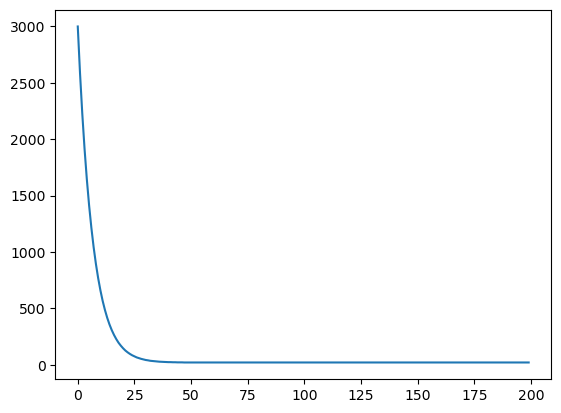

In [14]:
# int((epochs-min_epochs)*(1-i/200)**slope_epochs+min_epochs)
epochs=3000
min_epochs=20
plt.plot([int((epochs-min_epochs)*(1-i/200)**30+min_epochs) for i in range(200)])

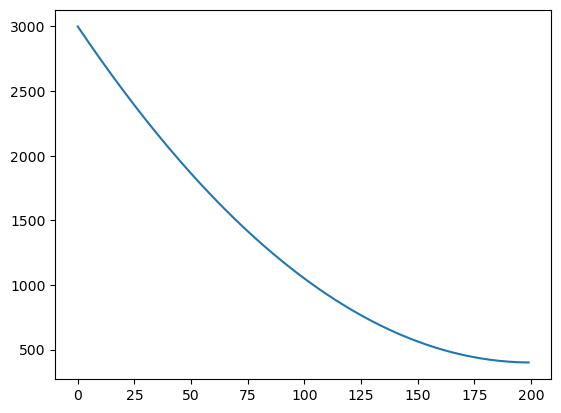

In [157]:
3000*(1-199/200)**2
plt.plot([2600*(1-i/200)**2+400 for i in range(200)])


In [123]:
dfme = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_n_chosen/","34")
dfme[["name","pesq","stoi"]]

,name,pesq,stoi
0,s0.07,1.175062,0.726310
1,s0.09,1.257077,0.772836
2,s0.1,1.313155,0.766077
3,s0.11,1.313804,0.773842
4,s0.15,1.364354,0.814172
5,s0.2,1.298248,0.821902
6,s0.23,1.273292,0.822576
7,s0.25,1.275882,0.836051
8,s0.28,1.256818,0.820454
9,s0.3,1.264820,0.818379


In [116]:
dfme = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_n_0_onetrain/","0")
dfme[["name","pesq","stoi"]]

,name,pesq,stoi
0,s0.09,2.068968,0.974681
1,noisy,1.511858,0.984783


In [100]:
dfme = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_n_0_onetrain/","0")
dfme[["name","pesq","stoi"]]

,name,pesq,stoi
0,s0.09,1.967577,0.972701
1,noisy,1.511858,0.984783


In [121]:
dfme = get_df(exp_root,"31")
dfme[["name","pesq","stoi"]]

,name,pesq,stoi
0,s0.05,1.124596,0.863871
1,s0.07,1.148005,0.910799
2,s0.09,1.235951,0.937121
3,s0.1,1.250722,0.944988
4,s0.11,1.251555,0.947469
5,s0.15,1.299376,0.965287
6,s0.2,1.314822,0.973114
7,s0.23,1.336285,0.971105
8,s0.25,1.318084,0.973752
9,s0.28,1.375084,0.980930


In [52]:
mine = None
df_noisy = None
for d in ["0"]: 
    if get_df(exp_root, d) is None:
        continue
    dfme = get_df(exp_root,d)
    dfme = dfme.assign(dir=d)
    cur_df_noisy = dfme[dfme["name"]=="noisy"].reset_index(drop=True)
    cur_df_noisy.loc[0,"dir"] = d
    if df_noisy is None:
        df_noisy = cur_df_noisy
    else:
        df_noisy = pd.concat([df_noisy, cur_df_noisy])
    dfme = dfme[dfme["name"] != "noisy"]
    
    dfme = dfme[dfme["stoi"]>0.5]

    for noisetype in NOISES :
        for c_snr in snrs:
            c_snr=str(c_snr)
            dfme_cur = dfme[dfme["snr"]==c_snr]
            cur_mine = dfme_cur[dfme_cur["noise_type"]==noisetype]
            cur_mine = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]
            if len(cur_mine)>0:
                print(noisetype,c_snr)
            if mine is None:
                mine = cur_mine
            else:
                mine = pd.concat([mine, cur_mine])
mine=mine.reset_index(drop=True)


0 21


In [49]:
s

'snr2'

In [50]:
snrs=[]
for d in os.listdir("/data/ephraim/datasets/known_noise/undiff_exps/exp_n_real/"):
    if not d in ['5f_snrs.pickle', 'storm', 'analysis','noises','noisy_wav','clean_wav']:
        enh_dir = Path(exp_root)/d/"enhanced_60"
        snr_dir=os.listdir(enh_dir)
        for s in snr_dir:
            c_snr = s.split("snr")[1]
            if c_snr not in snrs:
                snrs.append(c_snr)

In [51]:
snrs

['14',
 '21',
 '10',
 '9',
 '22',
 '16',
 '15',
 '3',
 '7',
 '0',
 '2',
 '11',
 '8',
 '12',
 '23',
 '24',
 '4',
 '1',
 '20',
 '18']

In [53]:
mine

,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,0,s0.09,0.971947,0.984783,1.955026,1.511858,2.928721,3.472559,3.486028,13.627638,14.914128,14.914128,inf,0,/data/ephraim/datasets/known_noise/undiff_exps...,21


In [57]:
exp_root = "/data/ephraim/datasets/known_noise/undiff_exps/exp_n_real/"
storm_enhanced_path = str( Path(exp_root)/"storm/enhanced/")
storm_clean_wav = str(Path(exp_root)/"storm"/"clean_wav")

cols =["dir","name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
mine = None
df_noisy = None


NOISES = [str(i) for i in range(35) if i!=5]
names = NOISES
snrs = []
for d in os.listdir("/data/ephraim/datasets/known_noise/undiff_exps/exp_n_real/"):
    if not d in ['5f_snrs.pickle', 'storm', 'analysis','noises','noisy_wav','clean_wav']:
        enh_dir = Path(exp_root)/d/"enhanced_60"
        snr_dir=os.listdir(enh_dir)
        for s in snr_dir:
            c_snr = s.split("snr")[1]
            if c_snr not in snrs:
                snrs.append(c_snr)


mine, df_noisy = create_mine_df(exp_root,df_noisy,mine,noises=NOISES,cols=cols,names=names,snrs=snrs)

analysis_root = os.path.join(exp_root, "analysis")
if not os.path.exists(analysis_root):
    os.mkdir(analysis_root)

SGMSE = "sgmseWSJ0"
STORM = "sgmseTIMIT"
storm_results_path = os.path.join(storm_enhanced_path,"sgmse_TIMITChime3/measures_storm.pickle")
sgmse_results_path = os.path.join(storm_enhanced_path,"sgmse_WSJ0Chime3/measures_storm.pickle")
df_storm = get_df_storm(storm_results_path)
df_sg = get_df_storm(sgmse_results_path)
write_results(mine,"ours",analysis_root=analysis_root, noises=NOISES)
write_results(df_sg,SGMSE,analysis_root=analysis_root, noises=NOISES)
write_results(df_storm,STORM,analysis_root=analysis_root, noises=NOISES)

df_storm = drop_rows_without_comparison(df_storm, mine)
df_sg= drop_rows_without_comparison(df_sg, mine)


minestats = get_stats_df(mine, "ours")
df_storm_stats = get_stats_df(df_storm, STORM)
df_sg_stats = get_stats_df(df_sg, SGMSE)
statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
statsdf_path = os.path.join(analysis_root,"all_stats.xlsx")
# statsdf.to_excel(statsdf_path)


for dir__ in names:
    dirminestats = get_stats_df(mine, "ours", dir__)
    dir_storm_stats =  get_stats_df(df_storm[cols], STORM, dir__)
    dir_sg_stats =  get_stats_df(df_sg[cols], SGMSE, dir__)
    dirstatsdf = pd.concat([dirminestats,dir_storm_stats,dir_sg_stats])
    dir_statsdf_path = os.path.join(analysis_root,f"{dir__}_stats.xlsx")
    # dirstatsdf.to_excel(dir_statsdf_path) 


for noisetype in NOISES:
    minestats = get_stats_df(mine, "ours", noise_type=noisetype)
    df_storm_stats = get_stats_df(df_storm[cols], STORM, noise_type=noisetype)
    df_sg_stats = get_stats_df(df_sg[cols], SGMSE, noise_type=noisetype)
    statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
    noise_statsdf_path = os.path.join(analysis_root,f"stats_{noisetype}.xlsx")
    # statsdf.to_excel(noise_statsdf_path)
    
for c_snr in snrs:
    c_snr = str(c_snr)
    minestats = get_stats_df(mine, "ours", snr_=c_snr)
    df_storm_stats = get_stats_df(df_storm[cols], STORM, snr_=c_snr)
    df_sg_stats = get_stats_df(df_sg[cols], SGMSE, snr_=c_snr)
    statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
    snr_statsdf_path = os.path.join(analysis_root,f"stats_snr{c_snr}.xlsx")
    # statsdf.to_excel(snr_statsdf_path)

wavs_analysis_path = Path(exp_root)/"analysis"/"wavs"
if not os.path.exists(wavs_analysis_path):
    os.mkdir(wavs_analysis_path)


# copy_wavs(mine, wavs_analysis_path, "ours")
# copy_wavs(df_sg, wavs_analysis_path, SGMSE)
# copy_wavs(df_storm, wavs_analysis_path, STORM)
# copy_wavs(df_noisy, wavs_analysis_path, "noisy")

wavs = glob(str(Path(storm_clean_wav)) + "/*.wav")
for wavpath in wavs:
    c = Path(wavpath).name.split("_")[0]
    if "snr" in wavpath:
        snr = wavpath.split("snr")[1].split("_")[0]
        noisetype = Path(wavpath).name.split("noise")[1].split("_")[0]
        name = f"{c}_{noisetype}_snr{snr}_clean.wav"
        dst = wavs_analysis_path/f"{name}"
        # shutil.copyfile(wavpath, dst)

df = mine    
for i in df.index.values:
    snr = df["snr"][i]
    noisetype = df["noise_type"][i]
    dir_ = df["dir"][i]
    s = float(df["name"][i].replace("s",""))
    wavpath = df["filename"][i]
    noisy_path = Path(exp_root) / dir_ / "noisy_wav" / Path(wavpath).name

    speech, sr = torchaudio.load(noisy_path)
    vaded_signal = calc_vad(noisy_path)[0:speech.shape[1],:]
    vaded_signal_torch = (speech[0][vaded_signal.T[0]>0])
    vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
    clean_power = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
    simple_power =  float(1 / speech.shape[1] * torch.sum(speech**2))
    vaded_rate = (vaded_signal_torch.shape[1]/speech.shape[1])
    
    variance = float( torch.var(speech, unbiased=True))
    df.at[i, "clean_power"] = clean_power
    df.at[i, "simple_power"] = simple_power
    df.at[i, "vaded_rate"] = vaded_rate
    df.at[i, "variance"] = variance
write_results(mine,"ours_params",analysis_root=analysis_root, noises=NOISES)

write
write
write


/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: inva

write


In [58]:
mine

,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr,clean_power,simple_power,vaded_rate,variance
0,0,s0.09,0.971947,0.984783,1.955026,1.511858,2.928721,3.472559,3.486028,13.627638,14.914128,14.914128,inf,0,/data/ephraim/datasets/known_noise/undiff_exps...,21,0.006138,0.003461,0.540,0.003461
1,1,s0.15,0.954210,0.967944,1.995473,1.630079,2.562694,2.898281,3.717436,17.312571,18.492893,18.492893,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,14,0.006356,0.003654,0.560,0.003654
2,2,s0.15,0.878151,0.833299,1.507527,1.154227,2.478644,3.030364,3.387752,4.854420,7.240263,7.240263,inf,2,/data/ephraim/datasets/known_noise/undiff_exps...,10,0.002034,0.001204,0.420,0.001204
3,3,s0.4,0.961441,0.999990,1.555822,4.453014,2.264576,2.670850,3.452825,12.499590,13.400295,13.400295,inf,3,/data/ephraim/datasets/known_noise/undiff_exps...,9,0.000945,0.000478,0.505,0.000478
4,4,s0.4,0.951069,0.990661,3.010700,4.455213,2.117840,3.033780,2.627027,18.193567,18.571499,18.571499,inf,4,/data/ephraim/datasets/known_noise/undiff_exps...,22,0.004264,0.003392,0.585,0.003392
5,6,s0.33,0.985060,0.998615,2.389352,3.672792,2.494085,3.257321,3.060121,20.574389,21.269716,21.269716,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,21,0.004199,0.002097,0.470,0.002098
6,7,s0.4,0.928401,0.925533,2.056950,2.132286,2.355043,2.987772,3.274032,20.460968,21.268587,21.268587,inf,7,/data/ephraim/datasets/known_noise/undiff_exps...,16,0.010198,0.003470,0.330,0.003471
7,8,s0.33,0.969826,0.994178,1.910270,2.547243,2.807882,3.261688,3.657481,17.341011,18.023066,18.023066,inf,8,/data/ephraim/datasets/known_noise/undiff_exps...,22,0.003602,0.001687,0.455,0.001687
8,9,s0.33,0.825623,0.986453,1.383483,1.497168,2.443382,3.227256,3.041546,-3.279818,-3.175937,-3.175937,inf,9,/data/ephraim/datasets/known_noise/undiff_exps...,3,0.011872,0.013480,0.350,0.013479
9,11,s0.1,0.905091,0.850558,1.515697,1.243633,2.682325,3.114246,3.623420,10.419924,12.201624,12.201624,inf,11,/data/ephraim/datasets/known_noise/undiff_exps...,7,0.008582,0.003752,0.370,0.003752


In [87]:
import pandas as pd

def compare_dataframes(df1, df2, id_col="dir"):
    """
    Compare two DataFrames based on a common identifier column. Handles numeric columns only.
    Only compares columns that exist in both DataFrames.

    Args:
        df1 (pd.DataFrame): First DataFrame.
        df2 (pd.DataFrame): Second DataFrame.
        id_col (str): The column name to use as the identifier for comparison.

    Returns:
        pd.DataFrame: A comparison report showing differences between metrics.
    """
    # Set the identifier column as the index
    df1 = df1.set_index(id_col)
    df2 = df2.set_index(id_col)

    # Get the intersection of columns that exist in both DataFrames
    common_columns = df1.columns.intersection(df2.columns)

    # Filter out columns with string or object data types
    numeric_columns = [col for col in common_columns if df1[col].dtype.kind in 'iuf' and df2[col].dtype.kind in 'iuf']

    # Align the DataFrames to handle missing rows
    df1_aligned, df2_aligned = df1[numeric_columns].align(df2[numeric_columns], join="outer", axis=0)

    # Create an empty DataFrame to store the comparison results
    comparison = pd.DataFrame(index=df1_aligned.index)

    # Iterate through the numeric columns to calculate the differences
    for column in numeric_columns:
        # Numeric comparison: calculate the difference
        comparison[f"{column}_diff"] = df1_aligned[column] - df2_aligned[column]

        # Add the original values from both DataFrames for reference
        comparison[f"{column}_df1"] = df1_aligned[column]
        comparison[f"{column}_df2"] = df2_aligned[column]

    # Reset index for a cleaner output
    comparison.reset_index(inplace=True)

    return comparison


# Compare the DataFrames
comparison_report = compare_dataframes(mine, df_storm)
comparison_report.head()

,dir,stoi_diff,stoi_df1,stoi_df2,input_stoi_diff,input_stoi_df1,input_stoi_df2,pesq_diff,pesq_df1,pesq_df2,...,si_sdr_df2,sdr_diff,sdr_df1,sdr_df2,sar_diff,sar_df1,sar_df2,sir_diff,sir_df1,sir_df2
0,0,-0.017406,0.971947,0.989352,0.0,0.984783,0.984783,-0.130444,1.955026,2.085470,...,19.149817,-5.308923,14.914128,20.223051,-5.308923,14.914128,20.223051,NaN,inf,inf
1,1,-0.026559,0.954210,0.980769,0.0,0.967944,0.967944,0.348690,1.995473,1.646783,...,10.564348,4.157827,18.492893,14.335066,4.157827,18.492893,14.335066,NaN,inf,inf
2,10,NaN,NaN,0.000010,NaN,NaN,0.000010,NaN,NaN,1.354299,...,9.419553,NaN,NaN,11.625541,NaN,NaN,11.625541,NaN,NaN,inf
3,11,-0.048504,0.905091,0.953594,0.0,0.850558,0.850558,0.230841,1.515697,1.284856,...,11.537142,-0.270390,12.201624,12.472015,-0.270390,12.201624,12.472015,NaN,inf,inf
4,12,-0.249266,0.725201,0.974467,0.0,0.918516,0.918516,-1.466782,1.036965,2.503747,...,8.489678,-9.502294,1.464940,10.967233,-9.502294,1.464940,10.967233,NaN,inf,inf


In [108]:
comparison_report.columns

Index(['dir', 'stoi_diff', 'stoi_df1', 'stoi_df2', 'input_stoi_diff',
       'input_stoi_df1', 'input_stoi_df2', 'pesq_diff', 'pesq_df1', 'pesq_df2',
       'input_pesq_diff', 'input_pesq_df1', 'input_pesq_df2', 'OVRL_diff',
       'OVRL_df1', 'OVRL_df2', 'SIG_diff', 'SIG_df1', 'SIG_df2', 'BAK_diff',
       'BAK_df1', 'BAK_df2', 'si_sdr_diff', 'si_sdr_df1', 'si_sdr_df2',
       'sdr_diff', 'sdr_df1', 'sdr_df2', 'sar_diff', 'sar_df1', 'sar_df2',
       'sir_diff', 'sir_df1', 'sir_df2'],
      dtype='object')

In [101]:
1.967577	-1.955026

0.012550999999999979

In [114]:
comparison_report[["pesq_diff","dir","pesq_df1","pesq_df2",'OVRL_diff','OVRL_df1', 'OVRL_df2',"input_pesq_df1"]]

,pesq_diff,dir,pesq_df1,pesq_df2,OVRL_diff,OVRL_df1,OVRL_df2,input_pesq_df1
0,-0.130444,0,1.955026,2.085470,-0.186050,2.928721,3.114771,1.511858
1,0.348690,1,1.995473,1.646783,-0.335719,2.562694,2.898413,1.630079
2,NaN,10,NaN,1.354299,NaN,NaN,1.775633,NaN
3,0.230841,11,1.515697,1.284856,-0.036803,2.682325,2.719128,1.243633
4,-1.466782,12,1.036965,2.503747,-0.298246,2.673488,2.971733,1.049655
5,-0.296198,13,1.710357,2.006555,-0.352288,2.964280,3.316569,1.920491
6,-0.342947,14,1.119233,1.462181,-1.198069,1.093724,2.291793,1.094843
7,0.252773,15,1.440099,1.187326,-0.031527,2.506479,2.538006,1.397057
8,-1.582339,16,2.691218,4.273557,0.026683,2.941700,2.915017,4.604765
9,-1.443578,17,1.579502,3.023080,-0.025220,2.548635,2.573854,1.459366


In [84]:
mine["BAK_raw"]

KeyError: 'BAK_raw'

In [77]:
df_storm["dir"][1]

'10'

In [68]:
s_array = []
snr_array = []
for j,n in enumerate(mine["name"]):
    n = float(n.split("s")[1])
    s_array.append(n)
    snr_ = float(mine["snr"][j])
    snr_array.append(snr_)

In [4]:
from matplotlib import pyplot as plt
# plt.plot(snr_array,s_array, ".")

,input_si_sdr,input_sdr,input_sir,input_sar,input_stoi,input_pesq,si_sdr,sdr,sir,sar,...,len_in_sec,sr,num_hops,OVRL_raw,SIG_raw,BAK_raw,OVRL,SIG,BAK,P808_MOS
0,19.044601,19.261939,inf,19.261939,0.984783,1.511858,19.149817,20.223051,inf,20.223051,...,1.0,16000,7,3.489866,3.866767,3.790649,3.114771,3.470394,3.811744,3.259311
11,15.845555,15.989218,inf,15.989218,0.967944,1.630079,10.564348,14.335066,inf,14.335066,...,1.0,16000,7,3.164615,3.406256,4.081295,2.898413,3.189435,3.978186,2.666927
1,11.635814,11.691771,inf,11.691771,0.000010,2.405081,9.419553,11.625541,inf,11.625541,...,1.0,16000,7,1.732680,2.067672,3.877525,1.775633,2.170534,3.863826,2.143417
2,7.037966,7.182994,inf,7.182994,0.850558,1.243633,11.537142,12.472015,inf,12.472015,...,1.0,16000,7,2.910105,3.475485,3.329777,2.719128,3.233946,3.502215,3.340996
3,-3.183176,-2.746943,inf,-2.746943,0.918516,1.049655,8.489678,10.967233,inf,10.967233,...,1.0,16000,7,3.272453,3.674097,3.939190,2.971733,3.357179,3.899588,3.212984
4,18.083784,18.231626,inf,18.231626,0.996507,1.920491,20.019300,22.028698,inf,22.028698,...,1.0,16000,7,3.814709,4.070766,4.349226,3.316569,3.583472,4.111916,3.203244
5,2.103903,2.286643,inf,2.286643,0.835145,1.094843,7.568219,10.530264,inf,10.530264,...,1.0,16000,7,2.347610,2.693429,3.510731,2.291793,2.684303,3.630416,2.557229
6,15.701641,15.767507,inf,15.767507,0.946110,1.397057,1.520924,6.051431,inf,6.051431,...,1.0,16000,7,2.664767,2.918439,3.952337,2.538006,2.852969,3.907083,3.415136
7,49.453979,49.558045,inf,49.558045,0.999989,4.604765,20.729753,22.245195,inf,22.245195,...,1.0,16000,7,3.188835,3.848099,3.405895,2.915017,3.459698,3.557193,3.300251
8,10.365370,10.429481,inf,10.429481,0.982477,1.459366,16.651371,17.326964,inf,17.326964,...,1.0,16000,7,2.712461,3.493174,2.948493,2.573854,3.245191,3.203859,2.993330


In [59]:
statsdf

,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,alg
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ours
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ours
mean,0.995513,1.0,3.970256,4.643888,2.577860,3.355454,3.131377,27.118950,28.821500,28.821500,inf,sgmseWSJ0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sgmseWSJ0
mean,0.998486,1.0,4.100904,4.643888,2.575442,3.346675,3.138208,26.510944,27.288822,27.288822,inf,sgmseTIMIT
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sgmseTIMIT


In [60]:
minestats = get_stats_df(mine, "ours")
df_storm_stats = get_stats_df(df_storm, STORM)
df_sg_stats = get_stats_df(df_sg, SGMSE)
statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])

/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [61]:
statsdf

,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,...,input_sdr,input_sir,input_sar,len_in_sec,sr,num_hops,OVRL_raw,SIG_raw,BAK_raw,P808_MOS
mean,0.902843,0.932955,1.787736,2.166166,2.417048,2.955266,3.189094,12.433356,13.301288,13.301288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.087789,0.087645,0.538746,1.160395,0.494887,0.577697,0.654102,7.038084,7.046334,7.046334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.926095,0.891024,2.540925,2.213294,2.655861,3.202192,3.481146,16.711723,17.663817,17.663817,...,24.680217,inf,24.680217,1.0,16000.0,7.0,2.843768,3.446596,3.375251,3.044913
std,0.181764,0.203897,0.988605,1.200482,0.355640,0.276429,0.531631,7.749667,7.650861,7.650861,...,47.901067,NaN,47.901067,0.0,0.0,0.0,0.479244,0.403448,0.650338,0.337169
mean,0.921770,0.891024,2.285547,2.213294,2.622242,3.156059,3.501604,15.440343,16.913946,16.913946,...,24.680217,inf,24.680217,1.0,16000.0,7.0,2.798898,3.380492,3.394395,3.045210
std,0.177343,0.203897,0.948069,1.200482,0.365645,0.317326,0.476935,6.741400,6.159339,6.159339,...,47.901067,NaN,47.901067,0.0,0.0,0.0,0.490236,0.451182,0.608629,0.363423
